In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import joblib

In [3]:
data = pd.read_excel('/private/wuchenpeng/projects/high-molecular/data/dup_log_01norm.xlsx')
# data = pd.read_excel('/private/wuchenpeng/projects/high-molecular/data/dup_log_01norm_new_test.xlsx')

In [3]:
# data

绘制3D曲线

In [4]:
adata = data[['redox', 'azo', 'fe', 'ybc', '温度', '浓度', 'AMPS', '[n]', '转化率（%）']]

平滑3D曲线

In [18]:
from matplotlib.font_manager import FontManager
import subprocess

mpl_fonts = set(f.name for f in FontManager().ttflist)

print('all font list get from matplotlib.font_manager:')
for f in sorted(mpl_fonts):
    print('\t' + f)

all font list get from matplotlib.font_manager:
	Abyssinica SIL
	Accanthis ADF Std
	Accanthis ADF Std No2
	Accanthis ADF Std No3
	Andale Mono
	Ani
	AnjaliOldLipi
	Arial
	Arial Black
	Arimo
	Asana Math
	Berenis ADF Pro
	Berenis ADF Pro Math
	C059
	Cabin
	Caladea
	Cantarell
	Carlito
	Chandas
	Charis SIL
	Chilanka
	Comfortaa
	Comic Sans MS
	Courier New
	Cousine
	D050000L
	DejaVu Math TeX Gyre
	DejaVu Sans
	DejaVu Sans Display
	DejaVu Sans Mono
	DejaVu Serif
	DejaVu Serif Display
	Dhurjati
	Droid Sans Fallback
	Dyuthi
	EB Garamond
	EB Garamond 12 All SC
	EB Garamond Initials
	EB Garamond Initials Fill1
	EB Garamond Initials Fill2
	EB Garamond SC
	FontAwesome
	FoulisGreek
	FreeMono
	FreeSans
	FreeSerif
	GFS Artemisia
	GFS Complutum
	GFS Didot
	GFS Neohellenic
	GFS Olga
	GFS Solomos
	Gargi
	Garuda
	Gayathri
	Gentium
	Gentium Basic
	Gentium Book Basic
	Gentium Book Plus
	Gentium Plus
	Gentium Plus Compact
	GentiumAlt
	Georgia
	Gidugu
	Gillius ADF
	Gillius ADF No2
	Go
	Go Medium
	Go Mono
	Go S

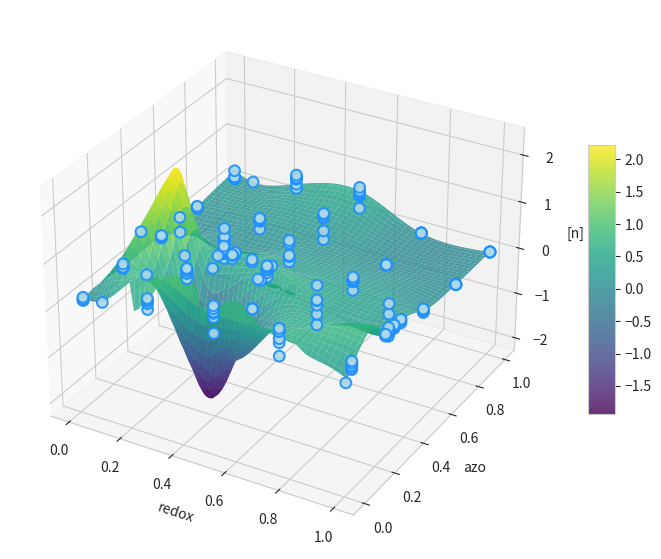

In [5]:
matplotlib.rc("font",family='Noto Sans CJK JP')

X_feature = adata['redox']
Y_feature = adata['azo']
Z_output = adata['[n]']

from scipy.interpolate import griddata

points = np.column_stack((X_feature, Y_feature))
values = Z_output

# 生成更密集的网格
X_dense = np.linspace(X_feature.min(), X_feature.max(), 100)
Y_dense = np.linspace(Y_feature.min(), Y_feature.max(), 100)
X, Y = np.meshgrid(X_dense, Y_dense)

# 使用三次样条插值（替代原来的循环填充方法）
Z = griddata(points, values, (X, Y), method='cubic')

# 绘制 3D 图像
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 修改后的曲面绘制参数（与[n]一致）
surface = ax.plot_surface(
    X, Y, Z,
    cmap="viridis",
    rstride=2,
    cstride=2,
    linewidth=0,
    antialiased=True,
    edgecolor='none',
    alpha=0.8
)

# 添加原始数据点（保持与之前一致的可视化风格）
scatter = ax.scatter3D(
    X_feature,
    Y_feature,
    Z_output,
    s=60,
    c='lightblue',
    edgecolors='dodgerblue',
    linewidth=1.5,
    alpha=0.9,
    depthshade=True,
    antialiased=True
)
# 添加轴标签
ax.set_xlabel("redox")
ax.set_ylabel("azo")
ax.set_zlabel("[n]")

# 添加颜色条
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)

plt.show()
# 其余代码保持不变...

/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36716 (\N{CJK UNIFIED IDEOGRAPH-8F6C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:17

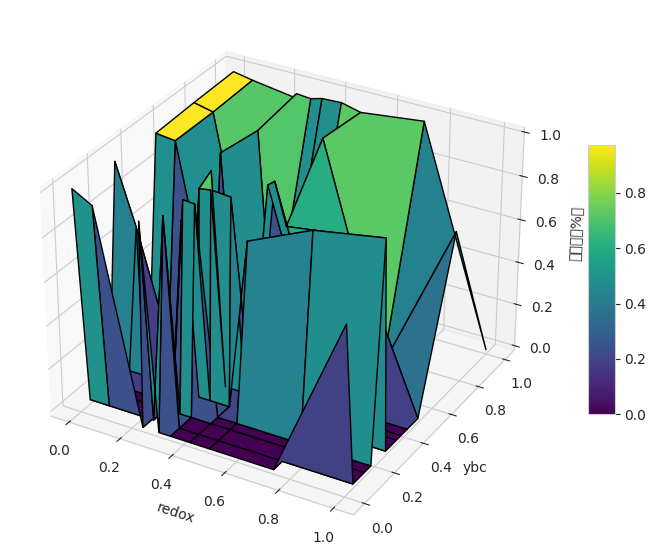

In [6]:
X_feature = adata['redox']
Y_feature = adata['ybc']
Z_output = adata['转化率（%）']
# 转换为网格数据，适合绘制 3D 曲面
X_unique = np.unique(X_feature)
Y_unique = np.unique(Y_feature)
X, Y = np.meshgrid(X_unique, Y_unique)

# 使用 DataFrame 数据生成 Z
Z = np.zeros_like(X, dtype=float)
for i in range(len(X_unique)):
    for j in range(len(Y_unique)):
        # 根据特征值查找对应的输出值
        value = data[(data['redox'] == X_unique[i]) & (data['ybc'] == Y_unique[j])]['转化率（%）']
        if not value.empty:
            Z[j, i] = value.values[0]
# 绘制 3D 图像
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 绘制曲面
surface = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="k")

# 添加轴标签
ax.set_xlabel("redox")
ax.set_ylabel("ybc")
ax.set_zlabel("转化率（%）")

# 添加颜色条
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)

plt.show()

训练

In [4]:
train_data, test_data = train_test_split(data, train_size=150, random_state=41)

In [5]:
# train_data = pd.read_excel('/private/wuchenpeng/projects/high-molecular/Third/train_data_2.xlsx')
# test_data = pd.read_excel('/private/wuchenpeng/projects/high-molecular/Third/test_data_2.xlsx')

In [8]:
# 特征和标签
X_train = train_data.iloc[:, :-2]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-2]
y_test = test_data.iloc[:, -1]

In [9]:
X_train

,redox,azo,fe,ybc,温度,浓度,AMPS
130,0.498925,0.037379,0.000000,0.498925,0.250000,0.40,0.1
67,0.498925,0.749386,0.227273,1.000000,0.250000,0.80,0.3
185,1.000000,0.315170,0.000000,1.000000,0.783333,0.12,0.0
128,0.075246,0.277938,0.170455,0.249900,0.250000,0.20,0.1
173,0.498925,0.403526,0.113636,1.000000,0.083333,0.60,0.5
...,...,...,...,...,...,...,...
65,1.000000,0.037379,0.113636,0.249900,0.083333,0.80,0.3
80,1.000000,0.277938,0.227273,0.739655,0.166667,0.40,0.4
140,0.075246,0.517655,0.000000,0.739655,0.333333,0.80,0.1
163,0.424207,0.403526,0.568182,1.000000,0.083333,0.60,0.5


In [10]:
y_test

96     0.980
63     0.960
165    0.981
195    0.990
68     0.930
9      0.987
158    0.945
91     0.000
51     0.000
160    0.953
30     0.700
117    0.943
29     0.965
14     0.980
146    0.943
147    0.948
90     0.970
190    0.970
38     0.990
134    0.970
104    1.000
11     0.920
49     0.980
183    0.970
167    0.955
164    0.946
123    0.962
107    0.525
61     0.907
193    0.980
66     0.000
99     0.980
22     0.973
54     0.970
149    0.968
46     0.990
144    0.960
42     0.960
41     0.000
106    1.000
55     0.640
181    0.960
180    0.950
83     0.600
101    0.000
23     0.960
Name: 转化率（%）, dtype: float64

In [11]:
# train_data.to_excel('train_data_2.xlsx',index=False)
# test_data.to_excel('test_data_2.xlsx',index=False)

In [12]:
# 特征缩放
scaler2 = StandardScaler()
X_train_scaled = scaler2.fit_transform(X_train)
X_test_scaled = scaler2.transform(X_test)

In [13]:
# 使用递归特征消除 (RFE) 进行特征选择
estimator = DecisionTreeRegressor()
selector = RFE(estimator, n_features_to_select=10, step=1)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=10 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


In [14]:
# 打印所选特征
selected_features = pd.Series(selector.support_, index=X_train.columns)
selected_feature_names = selected_features[selected_features].index.tolist()
print('Selected features:', selected_feature_names)

Selected features: ['redox', 'azo', 'fe', 'ybc', '温度', '浓度', 'AMPS']


In [15]:
# 使用随机森林回归器
rf_reg = RandomForestRegressor(n_estimators=90)
rf_reg.fit(X_train_selected, y_train)
y_pred = rf_reg.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Model performance (MSE, R2):', mse, r2)

Model performance (MSE, R2): 0.0069492317565754014 0.9261903839308209


In [16]:
# 不同算法对应的模型性能
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100),
    # 'Linear Regression': LinearRegression(),
    # 'SVR': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'GBT': GradientBoostingRegressor(n_estimators=100),
    # 'XGBR':XGBRegressor(n_estimators=100, learning_rate=0.1)
}

In [15]:
# model_save_path = '/private/wuchenpeng/projects/high-molecular/models/'
# 测试不同模型
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{name} performance (MSE, R2):', mse, r2)
    
    # 保存模型
    # joblib.dump(model, model_save_path + f'{name}_zhuanhualv_model.pkl')
    # print(f'{name} model saved to {model_save_path + f"{name}_zhuanhualv_model.pkl"}')
    
    # # 创建 R² 图
    # plt.figure(figsize=(10, 6))
    # plt.scatter(y_test, y_pred, color='blue', label=f'R² = {r2:.2f}', alpha=0.6)
    # # 绘制参考线（y_test = y_pred）
    # plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
    # plt.title(f'{name} R²')
    # plt.xlabel('True Values (y_test)')
    # plt.ylabel('Predicted Values (y_pred)')
    # plt.legend()
    # 
    # # 显示图表
    # plt.show()

Random Forest performance (MSE, R2): 0.009209708716847814 0.9021812643021565
Linear Regression performance (MSE, R2): 0.04126364558648154 0.5617279801510338
SVR performance (MSE, R2): 0.01387275829782861 0.8526537897064106
Decision Tree performance (MSE, R2): 0.004301690217391302 0.9543106181350521
GBT performance (MSE, R2): 0.01016079969974178 0.892079477118582


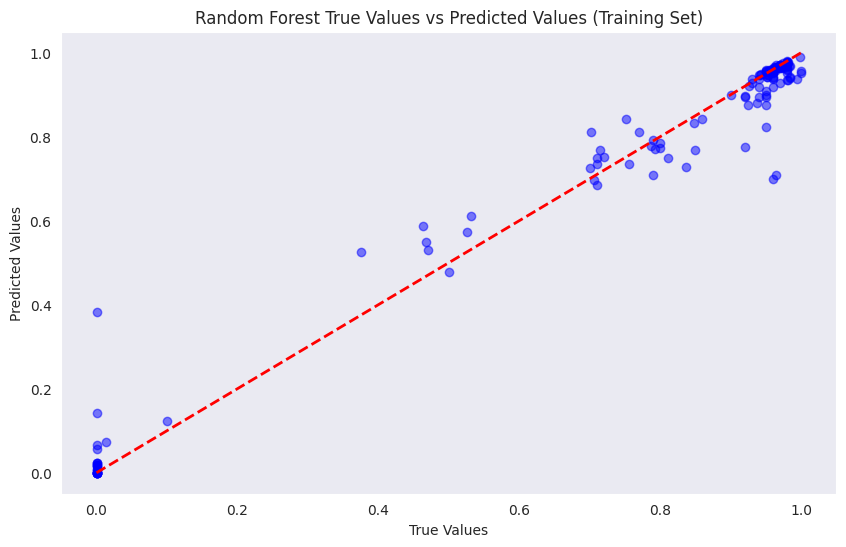

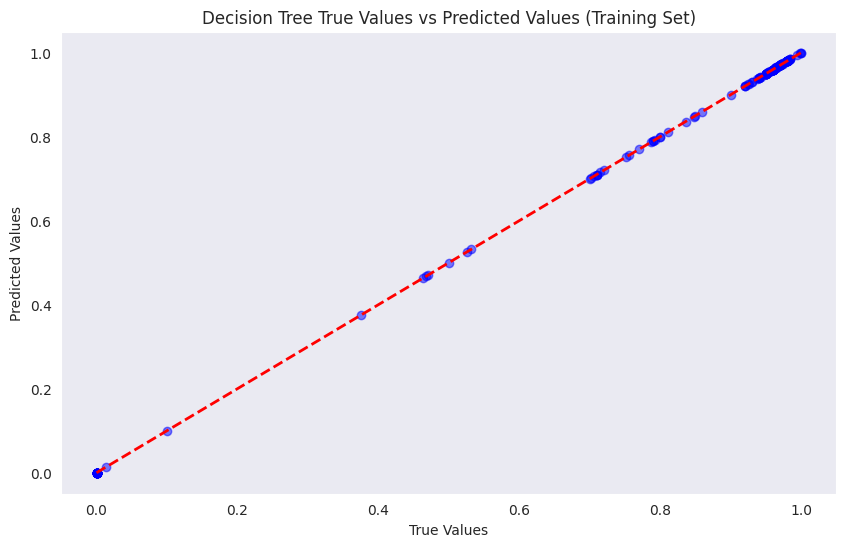

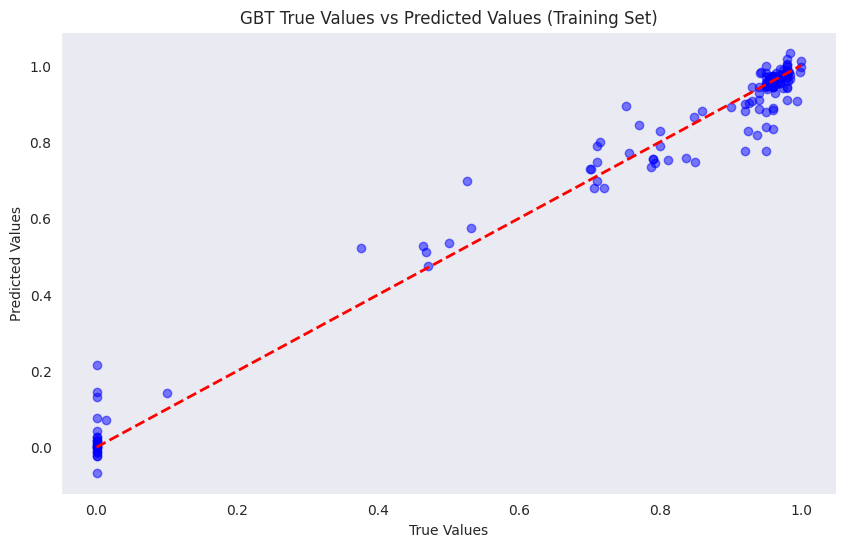

In [17]:
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_train_pred = model.predict(X_train_selected)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linewidth=2, linestyle='--')
    plt.title(f'{name} True Values vs Predicted Values (Training Set)')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.grid()
    plt.show()

/tmp/ipykernel_610110/3177468993.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='coolwarm')
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27987 (\N{CJK UNIFIED IDEOGRAPH-6D53}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


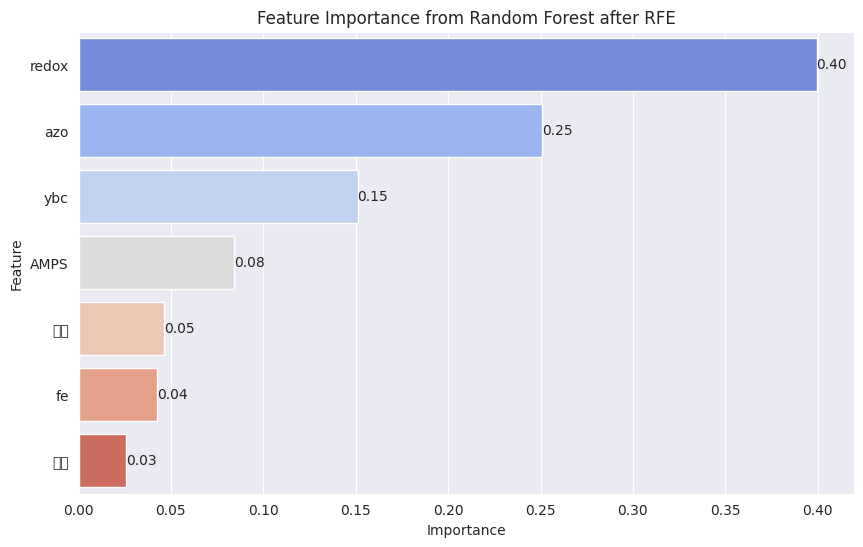

/tmp/ipykernel_610110/3177468993.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='coolwarm')
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27987 (\N{CJK UNIFIED IDEOGRAPH-6D53}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


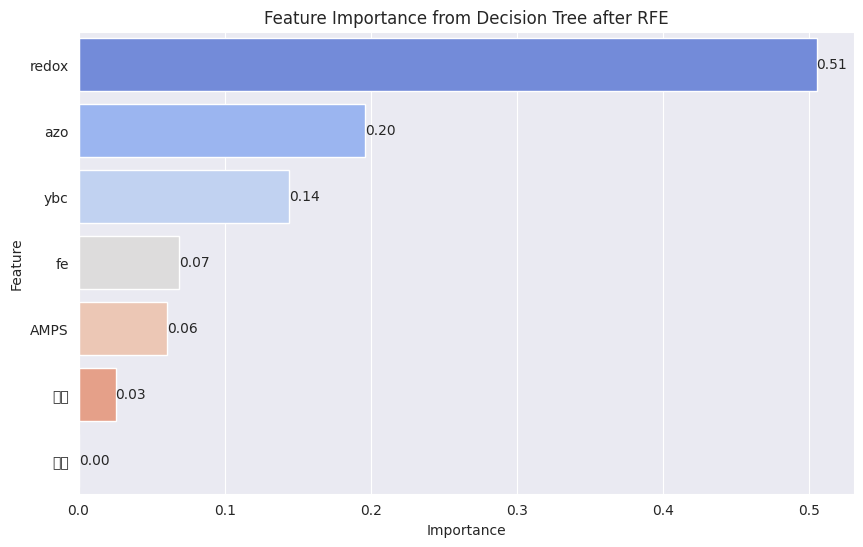

/tmp/ipykernel_610110/3177468993.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='coolwarm')
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27987 (\N{CJK UNIFIED IDEOGRAPH-6D53}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


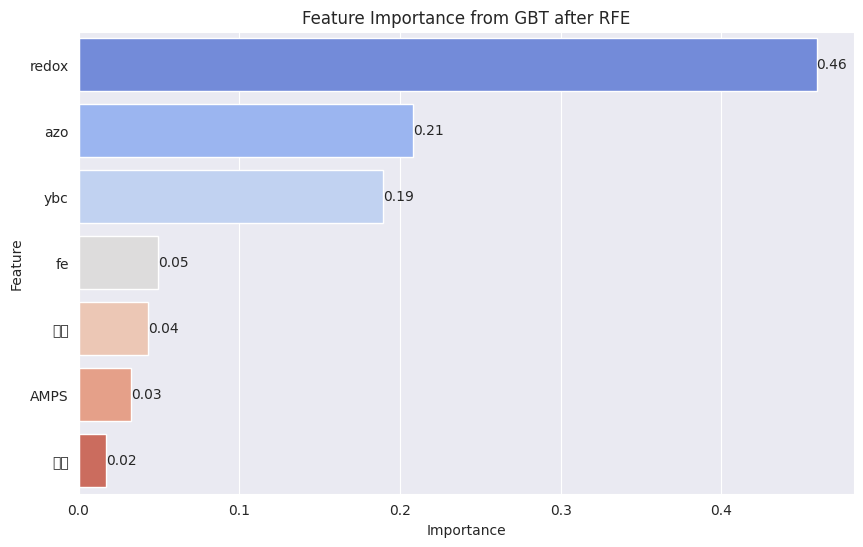

In [18]:
sel = selector.support_
# 创建特征名称列表
# fn = ['redox', 'azo', 'fe', 'ybc', '温度', '浓度', 'AMPS', 'combined_feature', 'combined_feature1', 'combined_feature2']
fn = ['redox', 'azo', 'fe', 'ybc', '温度', '浓度', 'AMPS']

sfn = [fn[i] for i, selected in enumerate(sel) if selected]

for name, mod in models.items():
    mod.fit(X_train_selected, y_train)
    # 获取选择后模型的特征重要性
    importances = mod.feature_importances_

    # 创建特征重要性 DataFrame
    feature_importance = pd.DataFrame({'Feature': sfn, 'Importance': importances})

    # 按照重要性降序排列
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # 可视化特征重要性
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='coolwarm')
    plt.title(f'Feature Importance from {name} after RFE')
    plt.xlabel('Importance')
    plt.ylabel('Feature')

    # 在条形图上显示特征重要性的数值
    for index, value in enumerate(feature_importance['Importance']):
        plt.text(value, index, f'{value:.2f}', va='center')

    plt.show()

In [ ]:
# # 使用网格搜索进行超参数优化
# param_grid = {
#     'n_estimators': [50, 80, 90, 100],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid_search = GridSearchCV(RandomForestRegressor(random_state=41), param_grid, cv=5)
# grid_search.fit(X_train_selected, y_train)
# print('Best parameters:', grid_search.best_params_)